In [1062]:
### uses sheet 1 from scb and  sheet åldersgrupp from fhm

#fhm_age_grp = pd.read_csv('fhm_dead_age_grp.csv',sep=';')

#fhm_dead = pd.read_csv('fhm_scb_dead.csv',sep=';',header=0,index_col=0,parse_dates=True,names=['fhm_dead'])

## NOTE! - assuming population 2020 grows as it did 2918-2019
## other prg's use mean of two consequtive years, or pop year before
## therefore this shows slightly different than eg scb_population

#### !!!!! ANOMALY in SCB data: historical death data for (at least ) 2019 from statistikdatabasen 
# http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101G/ManadFoddDod/table/tableViewLayout1/
# does not concur with death data 2019 in the preliminary data! 

### DUE to okänd dödsdag when using the daily data of the preliminary stuff - much more okänd dag than okänd månad in 
### the monthly stuff
####

# ALL DATA BASED ON SCB PREL DATA IGNORES THOSE WITH UNKNOWN DAY OF DEATH !!!

#### BEFORE USING, check that scb and fhm have about same number of days of data

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests

sns.set()


In [1063]:
def parse_scb_prel():
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=',')
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    df[['2015','2016','2017','2018','2019','2020','2015-2019']] = \
    df[['2015','2016','2017','2018','2019','2020','2015-2019']].astype(int)

    
    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    df = df.loc[df['2020'] != 0]
    
    #df = df.drop('Månad',axis=1)
    
    index = pd.date_range('2020-01-01',periods=len(df))
    df.index = index
    
    known_death_day = df.iloc[:,:7].sum()
    
    year_fraction = len(df) / 366
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] * year_fraction
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    all_deaths = pd.concat([all_deaths,df[['Månad','Dag']]],axis=1)
    
    return all_deaths

In [1064]:
scb_deaths = parse_scb_prel()
scb_deaths.rename(columns={'Dag' :'day'},inplace=True)
scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019,Månad,day
2020-01-01,298.082,250.398,347.327,282.527,309.139,260.704,297.633,januari,1
2020-01-02,274.842,277.992,324.786,320.54,284.408,307.918,296.61,januari,2
2020-01-03,283.936,299.455,317.614,303.075,279.255,262.757,296.61,januari,3
2020-01-04,258.675,265.728,312.491,292.801,290.59,279.179,284.337,januari,4
2020-01-05,270.8,265.728,311.467,298.965,283.377,271.995,286.382,januari,5
...,...,...,...,...,...,...,...,...,...
2020-08-17,212.194,214.626,216.183,230.131,214.336,190.909,217.855,augusti,17
2020-08-18,212.194,233.023,240.772,197.255,221.549,164.223,220.924,augusti,18
2020-08-19,243.518,217.693,252.042,209.584,212.275,89.2964,227.06,augusti,19
2020-08-20,220.278,236.089,231.551,197.255,237.006,37.9766,223.992,augusti,20


In [1065]:
def translate_month(m):
    if m == 'januari' : return  'January'
    if m == 'februari' : return 'February'
    if m == 'mars' : return 'March'
    if m == 'april' : return 'April'
    if m == 'maj' : return 'May'
    if m == 'juni' : return 'June'
    if m == 'juli' : return 'July'
    if m == 'augusti' : return 'August'
    if m == 'september' : return 'September'
    if m == 'oktober' : return 'October'
    if m == 'november' : return 'November'
    if m == 'december' : return 'December'
    
    
scb_deaths['month'] = scb_deaths['Månad'].apply(translate_month)

scb_deaths = scb_deaths.drop('Månad',axis=1)


scb_deaths.rename(columns={'Dag' : 'day'},inplace=True)
scb_deaths['year'] = '2020'

scb_deaths['day'] = scb_deaths['day'].astype(str)
    


In [1066]:
pd.datetime.strptime('2020'+ '-'+'January'+'-'+'31','%Y-%B-%d')

<ipython-input-1066-cab3d0352104>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime.strptime('2020'+ '-'+'January'+'-'+'31','%Y-%B-%d')


datetime.datetime(2020, 1, 31, 0, 0)

In [1067]:
def fix_date(s):
    return pd.datetime.strptime('2020'+'-'+s.month+'-'+s.day,'%Y-%B-%d')

scb_deaths['date'] = scb_deaths.apply(lambda row : fix_date(row),axis=1)

<ipython-input-1067-73ffea7828df>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime('2020'+'-'+s.month+'-'+s.day,'%Y-%B-%d')


In [1068]:
scb_deaths['date'] = pd.to_datetime(scb_deaths['date'])

In [1069]:
scb_deaths = scb_deaths.set_index('date')

In [1070]:
scb_deaths.drop(['day','month','year'],inplace=True,axis=1)

In [1071]:
last_day_mask = scb_deaths['2020'] != 0
scb_deaths = scb_deaths[last_day_mask]

scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019
date,,,,,,,
2020-01-01,298.082,250.398,347.327,282.527,309.139,260.704,297.633
2020-01-02,274.842,277.992,324.786,320.54,284.408,307.918,296.61
2020-01-03,283.936,299.455,317.614,303.075,279.255,262.757,296.61
2020-01-04,258.675,265.728,312.491,292.801,290.59,279.179,284.337
2020-01-05,270.8,265.728,311.467,298.965,283.377,271.995,286.382
...,...,...,...,...,...,...,...
2020-08-17,212.194,214.626,216.183,230.131,214.336,190.909,217.855
2020-08-18,212.194,233.023,240.772,197.255,221.549,164.223,220.924
2020-08-19,243.518,217.693,252.042,209.584,212.275,89.2964,227.06


In [1072]:
last_day = scb_deaths.index[-1].date()
print (last_day)
last_stable_day = (last_day - pd.DateOffset(days=7)).date()
last_stable_day

2020-08-21


datetime.date(2020, 8, 14)

In [1073]:
scb_deaths['excess'] = scb_deaths['2020'] - scb_deaths['2015-2019']
scb_deaths['cumexcess'] = scb_deaths['excess'].cumsum()
scb_deaths['excess_19'] = scb_deaths['2019'] - scb_deaths['2015-2019']
scb_deaths['cumexcess_19'] = scb_deaths['excess_19'].cumsum()
scb_deaths_orig = scb_deaths.copy()
scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019,excess,cumexcess,excess_19,cumexcess_19
date,,,,,,,,,,,
2020-01-01,298.082,250.398,347.327,282.527,309.139,260.704,297.633,-36.9289,-36.9289,11.5056,11.5056
2020-01-02,274.842,277.992,324.786,320.54,284.408,307.918,296.61,11.3081,-25.6208,-12.2027,-0.697098
2020-01-03,283.936,299.455,317.614,303.075,279.255,262.757,296.61,-33.8533,-59.4741,-17.355,-18.0521
2020-01-04,258.675,265.728,312.491,292.801,290.59,279.179,284.337,-5.15744,-64.6315,6.25361,-11.7985
2020-01-05,270.8,265.728,311.467,298.965,283.377,271.995,286.382,-14.3878,-79.0193,-3.00522,-14.8037
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-17,212.194,214.626,216.183,230.131,214.336,190.909,217.855,-26.9458,4040.08,-3.51899,-2381.86
2020-08-18,212.194,233.023,240.772,197.255,221.549,164.223,220.924,-56.7004,3983.38,0.625865,-2381.24
2020-08-19,243.518,217.693,252.042,209.584,212.275,89.2964,227.06,-137.764,3845.62,-14.7851,-2396.02


In [1074]:
scb_deaths.sum()['2019'] - scb_deaths.sum()['2015-2019']

-2404.9672131149637

In [1075]:
scb_deaths = scb_deaths.loc[:last_stable_day].copy()
scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019,excess,cumexcess,excess_19,cumexcess_19
date,,,,,,,,,,,
2020-01-01,298.082,250.398,347.327,282.527,309.139,260.704,297.633,-36.9289,-36.9289,11.5056,11.5056
2020-01-02,274.842,277.992,324.786,320.54,284.408,307.918,296.61,11.3081,-25.6208,-12.2027,-0.697098
2020-01-03,283.936,299.455,317.614,303.075,279.255,262.757,296.61,-33.8533,-59.4741,-17.355,-18.0521
2020-01-04,258.675,265.728,312.491,292.801,290.59,279.179,284.337,-5.15744,-64.6315,6.25361,-11.7985
2020-01-05,270.8,265.728,311.467,298.965,283.377,271.995,286.382,-14.3878,-79.0193,-3.00522,-14.8037
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-10,230.382,217.693,198.765,226.022,240.098,201.173,222.969,-21.7958,4167.03,17.1286,-2349.19
2020-08-11,223.309,221.781,217.207,199.31,209.184,229.912,213.764,16.1484,4183.17,-4.58013,-2353.77
2020-08-12,207.142,232.001,222.33,207.529,244.22,204.253,222.969,-18.7166,4164.46,21.2505,-2332.51


In [1076]:
scb_deaths.sum()

2015             57776.388513
2016             56620.510408
2017             57844.732925
2018             58768.751234
2019             55035.982840
2020             61552.907396
2015-2019        57404.342648
excess            4148.564748
cumexcess       358516.675639
excess_19        -2368.359808
cumexcess_19   -351513.808485
dtype: float64

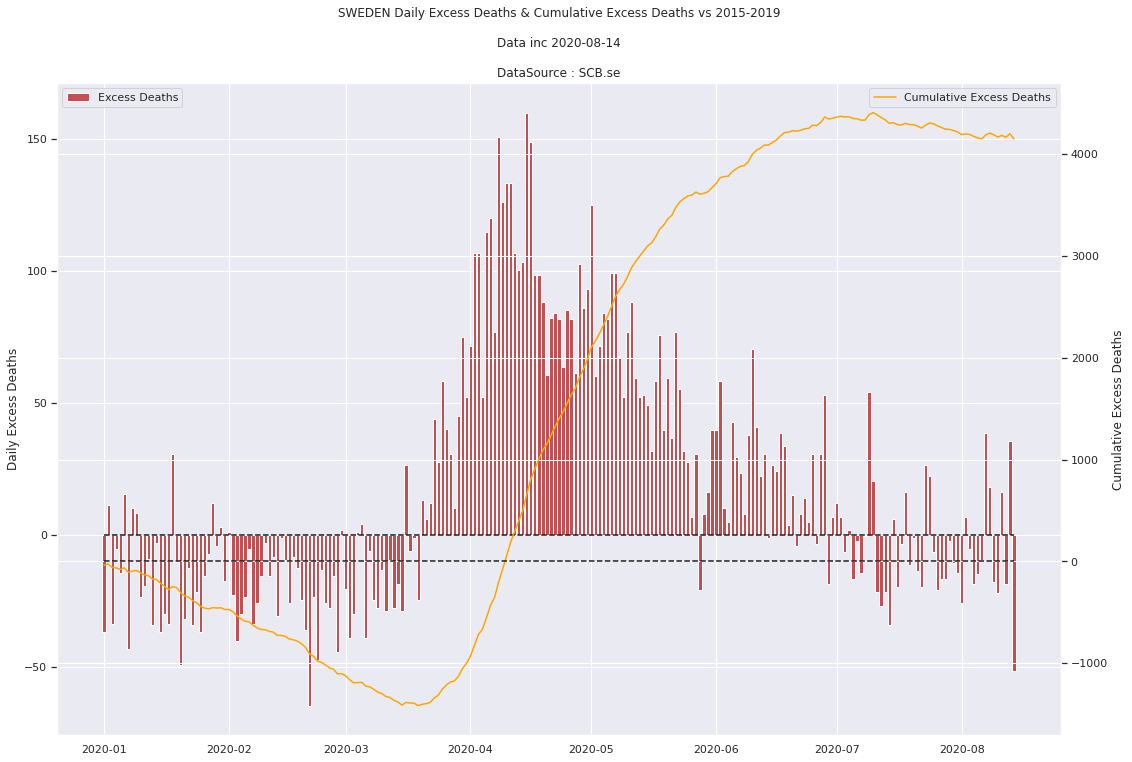

In [1077]:

plt.figure(figsize=(18,12))
plt.title('SWEDEN Daily Excess Deaths & Cumulative Excess Deaths vs 2015-2019\n\nData inc {}\n\n'.format(last_stable_day)+\
         'DataSource : SCB.se')
ax = plt.gca()
ax2 = plt.twinx()
ax.bar(scb_deaths.index,scb_deaths['excess'],color='r',label='Excess Deaths')
ax.plot(scb_deaths.index,[0] * len(scb_deaths.index),color='k',ls='dashed')

ax2.plot(scb_deaths.index,scb_deaths['cumexcess'],color='orange',label='Cumulative Excess Deaths')
ax2.plot(scb_deaths.index,[0] * len(scb_deaths.index),color='k',ls='dashed')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_ylabel('Daily Excess Deaths')
ax2.set_ylabel('Cumulative Excess Deaths')
plt.savefig('fhm_scb_excess.jpg',format='jpg')

In [1078]:
### population 2015-2019
url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'
data = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:ÅlderTotA",
        "values": []
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2014",  
          "2015",
          "2016",
          "2017",
          "2018",
          "2019"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [1079]:
r = requests.post(url,json=data)
r.status_code

200

In [1080]:
json = r.json()

In [1081]:
json['data'][0]

{'key': ['1', '2014'], 'values': ['4872240']}

In [1082]:
data_list = []

for rec in range(len(json['data'])):
    data_list.append((json['data'][rec]['key'][0],json['data'][rec]['key'][1],json['data'][rec]['values'][0]))

In [1083]:
population = pd.DataFrame(data_list,columns=['gender','year','population'])
population = population.set_index('year')
population['population'] = population['population'].astype(int)

In [1084]:
population

,gender,population
year,,
2014,1,4872240
2015,1,4930966
2016,1,5013347
2017,1,5082662
2018,1,5142438
2019,1,5195814
2014,2,4875115
2015,2,4920051
2016,2,4981806


In [1085]:
population = population.groupby(population.index).sum()
population['growth'] = population['population'] / population['population'].shift()


population.loc['2020','population'] = population.loc['2019','population']  
population['population'] = population['population'].astype(int)
population

,population,growth
year,,
2014,9747355,NaN
2015,9851017,1.010635
2016,9995153,1.014632
2017,10120242,1.012515
2018,10230185,1.010864
2019,10327589,1.009521
2020,10327589,NaN


In [1086]:
scb_deaths_ytd = scb_deaths.sum()
scb_deaths_ytd = scb_deaths_ytd.drop(['2015-2019','excess','cumexcess'])
scb_deaths_ytd

2015             57776.388513
2016             56620.510408
2017             57844.732925
2018             58768.751234
2019             55035.982840
2020             61552.907396
excess_19        -2368.359808
cumexcess_19   -351513.808485
dtype: float64

In [1087]:
deaths_per_M_ytd = scb_deaths_ytd / (population['population'] / 1e6)
deaths_per_M_ytd.drop('2014',inplace=True)
deaths_per_M_ytd

2015            5865.017644
2016            5664.796768
2017            5715.746019
2018            5744.642080
2019            5329.025278
2020            5960.046183
cumexcess_19            NaN
excess_19               NaN
dtype: float64

In [1088]:
scb_deaths

,2015,2016,2017,2018,2019,2020,2015-2019,excess,cumexcess,excess_19,cumexcess_19
date,,,,,,,,,,,
2020-01-01,298.082,250.398,347.327,282.527,309.139,260.704,297.633,-36.9289,-36.9289,11.5056,11.5056
2020-01-02,274.842,277.992,324.786,320.54,284.408,307.918,296.61,11.3081,-25.6208,-12.2027,-0.697098
2020-01-03,283.936,299.455,317.614,303.075,279.255,262.757,296.61,-33.8533,-59.4741,-17.355,-18.0521
2020-01-04,258.675,265.728,312.491,292.801,290.59,279.179,284.337,-5.15744,-64.6315,6.25361,-11.7985
2020-01-05,270.8,265.728,311.467,298.965,283.377,271.995,286.382,-14.3878,-79.0193,-3.00522,-14.8037
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-10,230.382,217.693,198.765,226.022,240.098,201.173,222.969,-21.7958,4167.03,17.1286,-2349.19
2020-08-11,223.309,221.781,217.207,199.31,209.184,229.912,213.764,16.1484,4183.17,-4.58013,-2353.77
2020-08-12,207.142,232.001,222.33,207.529,244.22,204.253,222.969,-18.7166,4164.46,21.2505,-2332.51


In [1089]:
scb_deaths.loc['2020-01-01' : '2020-07-31','2019'].sum()

51905.43712900954

In [1090]:
population

,population,growth
year,,
2014,9747355,NaN
2015,9851017,1.010635
2016,9995153,1.014632
2017,10120242,1.012515
2018,10230185,1.010864
2019,10327589,1.009521
2020,10327589,NaN


In [1091]:
scb_deaths.loc['2020-01-01' : '2020-07-31','2019'].sum()

51905.43712900954

In [1092]:
scb_deaths.loc['2020-01-01' : '2020-07-31','2019'].sum() / population.loc['2019','population']

0.005025900733366668

In [1093]:
maximums = pd.concat ([scb_deaths.max(),
            pd.Series(scb_deaths.index[scb_deaths.apply(np.argmax)].values,
                      index=scb_deaths.max().index)],axis=1)
maximums.columns = ['max','date_of_max']
maximums

,max,date_of_max
2015,340.520872,2020-02-20
2016,322.961756,2020-01-25
2017,347.326587,2020-01-01
2018,344.169566,2020-02-26
2019,309.138813,2020-01-01
2020,408.505205,2020-04-15
2015-2019,298.656001,2020-02-20
excess,159.966136,2020-04-15
cumexcess,4406.784125,2020-07-10
excess_19,29.670526,2020-04-19


In [1094]:
minimums = pd.concat ([scb_deaths.min(),
            pd.Series(scb_deaths.index[scb_deaths.apply(np.argmin)].values,
                      index=scb_deaths.min().index)],axis=1)
minimums.columns = ['min','date_of_min']
minimums

,min,date_of_min
2015,0.000000,2020-02-29
2016,191.119773,2020-06-06
2017,0.000000,2020-02-29
2018,0.000000,2020-02-29
2019,0.000000,2020-02-29
2020,173.460753,2020-08-14
2015-2019,208.650083,2020-06-11
excess,-64.641544,2020-02-21
cumexcess,-1416.931385,2020-03-19
excess_19,-248.539069,2020-02-29


In [1095]:
daily_deaths_per_M = scb_deaths.loc[:,'2015' : '2020'].div(population['population'] / 1e6,axis=1)
daily_deaths_per_M.drop('2014',axis=1,inplace=True)
daily_deaths_per_M 

,2015,2016,2017,2018,2019,2020
date,,,,,,
2020-01-01,30.259,25.0519,34.32,27.617,29.9333,25.2435
2020-01-02,27.8998,27.8127,32.0927,31.3328,27.5386,29.8151
2020-01-03,28.823,29.96,31.3841,29.6255,27.0397,25.4423
2020-01-04,26.2587,26.5857,30.8779,28.6213,28.1373,27.0324
2020-01-05,27.4895,26.5857,30.7766,29.2238,27.4389,26.3367
...,...,...,...,...,...,...
2020-08-10,23.3866,21.7798,19.6403,22.0936,23.2482,19.4792
2020-08-11,22.6686,22.1888,21.4626,19.4826,20.2549,22.262
2020-08-12,21.0275,23.2114,21.9688,20.286,23.6473,19.7774


In [1096]:
daily_deaths_per_M.sum()

2015    5865.017644
2016    5664.796768
2017    5715.746019
2018    5744.642080
2019    5329.025278
2020    5960.046183
dtype: float64

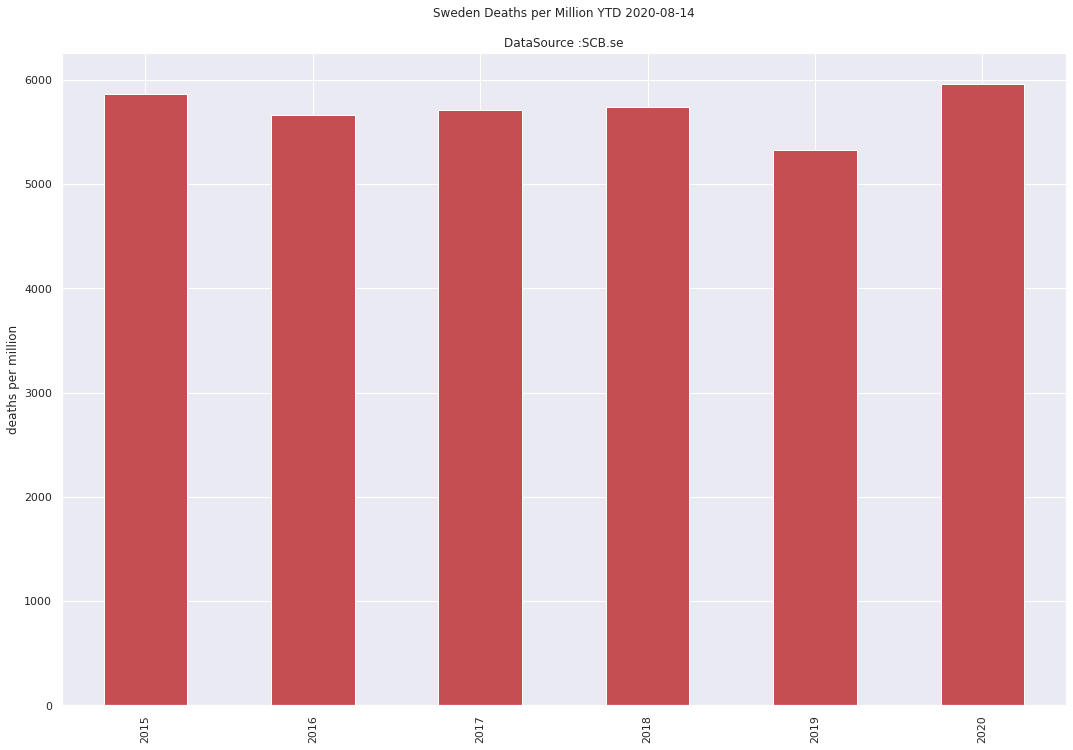

In [1097]:
daily_deaths_per_M.sum().plot(kind='bar',
                              figsize=(18,12),
                              color='r',
                              title='Sweden Deaths per Million YTD {}\n\nDataSource :SCB.se'.format(last_stable_day))
plt.ylabel('deaths per million')
plt.savefig('fhm_scb_deaths_per_M.jpg',format='jpg')

In [1098]:
daily_deaths_per_M_2015_2019_avg = daily_deaths_per_M[['2015','2016','2017','2018','2019']].mean(axis=1)
daily_deaths_per_M_2015_2019_avg

date
2020-01-01    29.436245
2020-01-02    29.335339
2020-01-03    29.366472
2020-01-04    28.096161
2020-01-05    28.302910
                ...    
2020-08-10    22.029721
2020-08-11    21.211502
2020-08-12    22.028182
2020-08-13    21.433973
2020-08-14    22.309410
Length: 227, dtype: float64

Text(0, 0.5, 'deaths per million per day')

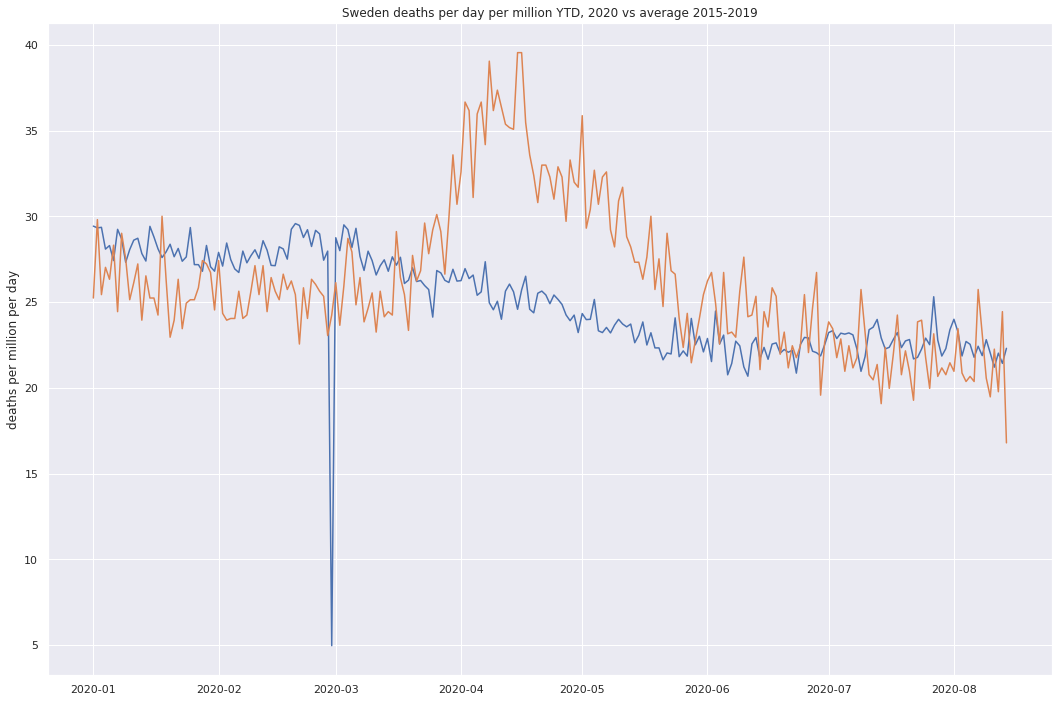

In [1099]:
plt.figure(figsize=(18,12))
plt.plot(daily_deaths_per_M_2015_2019_avg)
plt.plot(daily_deaths_per_M['2020'])
plt.title('Sweden deaths per day per million YTD, 2020 vs average 2015-2019')
plt.ylabel('deaths per million per day')

In [1100]:
import calendar
d = dict(enumerate(calendar.month_abbr))

In [1101]:
monthly_deaths_per_M = daily_deaths_per_M.groupby(daily_deaths_per_M.index.month).sum()
month_names = pd.Series(monthly_deaths_per_M.index.values).map(d)
month_names
monthly_deaths_per_M.index = month_names
monthly_deaths_per_M.index.name = 'month'
monthly_deaths_per_M

,2015,2016,2017,2018,2019,2020
month,,,,,,
Jan,885.922408,874.055646,921.375262,861.450269,815.582629,806.996415
Feb,827.455837,784.482325,797.256366,818.568564,727.778284,731.961650
Mar,884.076096,818.941468,817.605385,924.919210,755.316919,831.345445
Apr,789.196134,757.283120,765.973545,764.740476,717.002296,1030.609954
May,749.910701,714.848271,742.283641,680.684300,695.649876,864.639016
Jun,694.111027,668.936831,673.744903,652.665575,643.765491,718.047918
Jul,721.703145,724.357767,686.197289,728.988984,670.805238,677.499330
Aug,312.642295,321.891340,311.309629,312.624701,303.124544,298.946455


In [1102]:
monthly_deaths_per_M.sum()

2015    5865.017644
2016    5664.796768
2017    5715.746019
2018    5744.642080
2019    5329.025278
2020    5960.046183
dtype: float64

In [1103]:
ytd_deaths_per_M_avg = monthly_deaths_per_M.loc[:,:'2019'].sum().mean()
ytd_deaths_per_M_avg

5663.845557606479

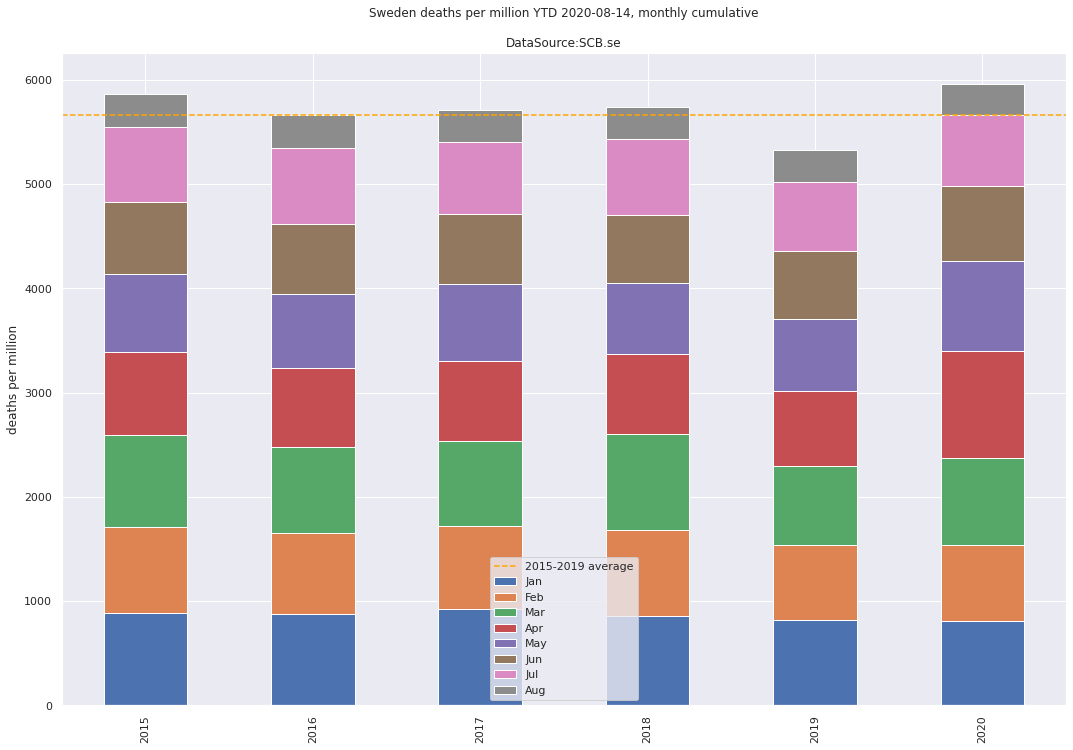

In [1104]:
monthly_deaths_per_M.T.plot(kind='bar',
                            stacked=True,figsize=(18,12),
                           title='Sweden deaths per million YTD {}, monthly cumulative\n\nDataSource:SCB.se'.format(
                               last_stable_day))
plt.ylabel('deaths per million')
plt.axhline(ytd_deaths_per_M_avg,ls='dashed',color='orange',label='2015-2019 average')
plt.legend(loc='lower center')

plt.savefig('fhm_deaths_per_M_stacked_monthly_YTD.jpg',format='jpg')

In [1105]:
# FHM excel sheed döda åldersgrupp
fhm_age_grp = pd.read_csv('fhm_dead_age_grp.csv',sep=';')
age_grp = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90+']
fhm_age_grp.drop('Åldersgrupp',axis=1,inplace=True)
fhm_cols = ['cases','icu','dead']
fhm_age_grp.columns = fhm_cols
fhm_age_grp['age_grp'] = age_grp
fhm_age_grp.set_index('age_grp',inplace=True,drop=True)
fhm_age_grp

,cases,icu,dead
age_grp,,,
0-9,575,8,1
10-19,3780,15,0
20-29,13770,94,10
30-39,13477,118,16
40-49,14279,285,45
50-59,15284,652,162
60-69,8664,768,399
70-79,6023,505,1252
80-89,6620,107,2411


In [1106]:
print (fhm_age_grp.sum())
scb_deaths['2020'].sum()

cases    86050
icu       2556
dead      5810
dtype: int64


61552.90739553012

/usr/local/lib64/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


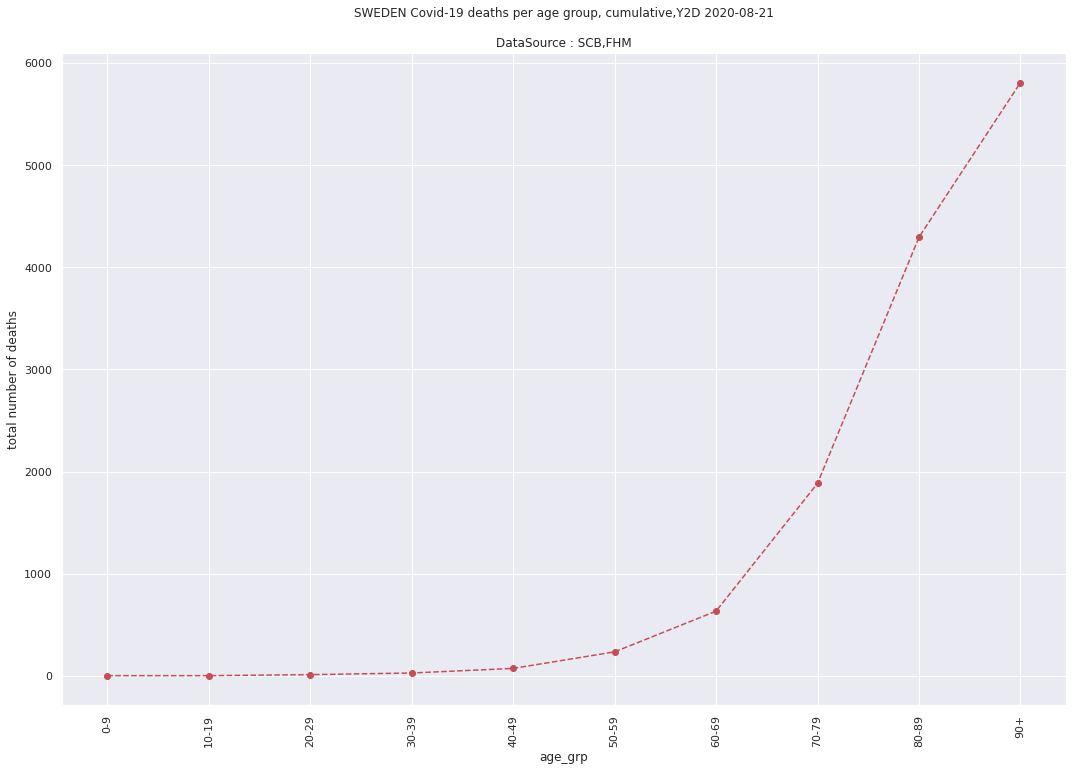

In [1107]:
fhm_age_grp['dead'].cumsum().plot(style='ro--',
                                  title='SWEDEN Covid-19 deaths per age group, cumulative,Y2D {}\n\nDataSource : SCB,FHM'.format(last_day),
                                  figsize=(18,12))
plt.ylabel('total number of deaths')
_= plt.xticks(range(len(fhm_age_grp)),age_grp,rotation=90)
plt.savefig('fhm_scb_cumulative_covid_deaths.jpg',format='jpg')

In [1108]:
# population stratified

url2 = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'

data2 = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:Ålder1årA",
        "values": [
          "0",
          "1",
          "2",
          "3",
          "4",
          "5",
          "6",
          "7",
          "8",
          "9",
          "10",
          "11",
          "12",
          "13",
          "14",
          "15",
          "16",
          "17",
          "18",
          "19",
          "20",
          "21",
          "22",
          "23",
          "24",
          "25",
          "26",
          "27",
          "28",
          "29",
          "30",
          "31",
          "32",
          "33",
          "34",
          "35",
          "36",
          "37",
          "38",
          "39",
          "40",
          "41",
          "42",
          "43",
          "44",
          "45",
          "46",
          "47",
          "48",
          "49",
          "50",
          "51",
          "52",
          "53",
          "54",
          "55",
          "56",
          "57",
          "58",
          "59",
          "60",
          "61",
          "62",
          "63",
          "64",
          "65",
          "66",
          "67",
          "68",
          "69",
          "70",
          "71",
          "72",
          "73",
          "74",
          "75",
          "76",
          "77",
          "78",
          "79",
          "80",
          "81",
          "82",
          "83",
          "84",
          "85",
          "86",
          "87",
          "88",
          "89",
          "90",
          "91",
          "92",
          "93",
          "94",
          "95",
          "96",
          "97",
          "98",
          "99",
          "100+"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2019"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [1109]:
r2 = requests.post(url2,json=data2)
r2.status_code

200

In [1110]:
json2 = r2.json()
json2['data'][0]

{'key': ['0', '1', '2019'], 'values': ['59476']}

In [1111]:
data2_list = []

for rec2 in range(len(json2['data'])):
    
    data2_list.append((json2['data'][rec2]['key'][0],json2['data'][rec2]['key'][1],json2['data'][rec2]['key'][2],
                      json2['data'][rec2]['values'][0]))

In [1112]:
population_age_grp = pd.DataFrame(data=data2_list,columns=['age_grp','gender','year','pop'])
population_age_grp['pop'] = population_age_grp['pop'].astype(int)
population_age_grp['age_grp'] = population_age_grp['age_grp'].apply(lambda s : s.replace('+',''))
population_age_grp['age_grp'] = population_age_grp['age_grp'].astype(int)
population_age_grp

,age_grp,gender,year,pop
0,0,1,2019,59476
1,0,2,2019,55907
2,1,1,2019,60993
3,1,2,2019,57783
4,2,1,2019,61598
...,...,...,...,...
197,98,2,2019,2126
198,99,1,2019,377
199,99,2,2019,1477
200,100,1,2019,375


In [1113]:
population_age_grp = pd.pivot_table(population_age_grp,index='age_grp',columns='gender',values='pop')
population_age_grp

gender,1,2
age_grp,,
0,59476,55907
1,60993,57783
2,61598,58432
3,63965,60716
4,63535,59313
...,...,...
96,1372,3869
97,917,2738
98,583,2126


In [1114]:
population_age_grp['pop'] = population_age_grp.sum(axis=1)
population_age_grp.drop(['1','2'],axis=1,inplace=True)


In [1115]:
population_age_grp = pd.Series(population_age_grp['pop'])
population_age_grp

age_grp
0      115383
1      118776
2      120030
3      124681
4      122848
        ...  
96       5241
97       3655
98       2709
99       1854
100      2207
Name: pop, Length: 101, dtype: int64

In [1116]:
population_age_grp.loc['30':'39'].sum()

1366489

In [1117]:
population_age_grp

age_grp
0      115383
1      118776
2      120030
3      124681
4      122848
        ...  
96       5241
97       3655
98       2709
99       1854
100      2207
Name: pop, Length: 101, dtype: int64

In [1118]:
zero_9 = pd.Series(population_age_grp.loc[0:9].sum())
ten_19 = pd.Series(population_age_grp.loc[10:19].sum())
twenty_29 = pd.Series(population_age_grp.loc[20:29].sum())
thirty_39 = pd.Series(population_age_grp.loc[30:39].sum())
forty_49 = pd.Series(population_age_grp.loc[40:49].sum())
fifty_59 = pd.Series(population_age_grp.loc[50:59].sum())
sixty_69 = pd.Series(population_age_grp.loc[60:69].sum())
seventy_79 = pd.Series(population_age_grp.loc[70:79].sum())
eighty_89 = pd.Series(population_age_grp.loc[80:89].sum())
ninety_plus = pd.Series(population_age_grp.loc[90:].sum())

thirty_39

0    1366489
dtype: int64

In [1119]:
population_age_grp = pd.DataFrame([zero_9,ten_19,twenty_29,thirty_39,forty_49,fifty_59,
                               sixty_69,seventy_79,eighty_89,ninety_plus],index=age_grp)

population_age_grp.rename(columns={0:'pop'},inplace=True)

population_age_grp

,pop
0-9,1225802
10-19,1177928
20-29,1327395
30-39,1366489
40-49,1298355
50-59,1297863
60-69,1108438
70-79,989013
80-89,436679
90+,99627


In [1120]:
population_age_grp['pop'].sum()

10327589

In [1121]:
population_age_grp

,pop
0-9,1225802
10-19,1177928
20-29,1327395
30-39,1366489
40-49,1298355
50-59,1297863
60-69,1108438
70-79,989013
80-89,436679
90+,99627


In [1122]:
fhm_age_grp

,cases,icu,dead
age_grp,,,
0-9,575,8,1
10-19,3780,15,0
20-29,13770,94,10
30-39,13477,118,16
40-49,14279,285,45
50-59,15284,652,162
60-69,8664,768,399
70-79,6023,505,1252
80-89,6620,107,2411


In [1123]:
covid_dead_per_age_grp = fhm_age_grp['dead'] / population_age_grp['pop']
covid_dead_per_age_grp

age_grp
0-9      8.157924e-07
10-19    0.000000e+00
20-29    7.533553e-06
30-39    1.170884e-05
40-49    3.465924e-05
50-59    1.248206e-04
60-69    3.599660e-04
70-79    1.265909e-03
80-89    5.521218e-03
90+      1.519668e-02
dtype: float64

Text(0, 0.5, 'percent of age group')

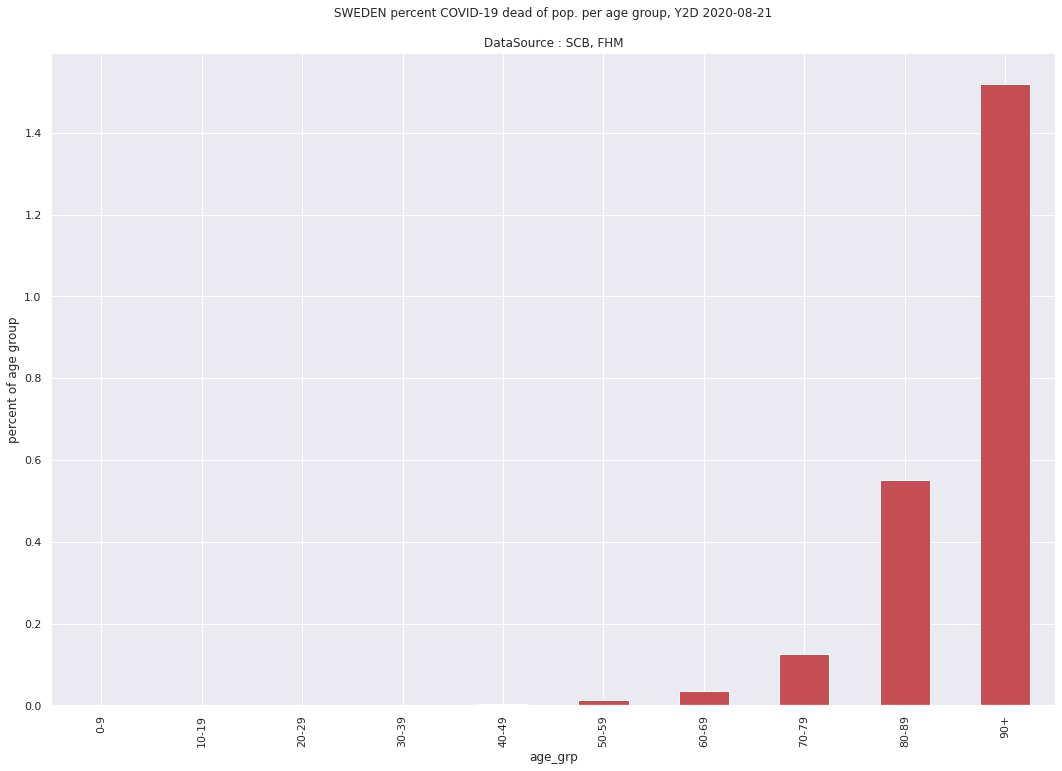

In [1124]:
(100 * covid_dead_per_age_grp).plot(kind='bar',color='r',figsize=(18,12),
                                    title='SWEDEN percent COVID-19 dead of pop. per age group, Y2D {}\n\nDataSource : SCB, FHM'.format(last_day))
plt.ylabel('percent of age group')
#plt.yscale('log')

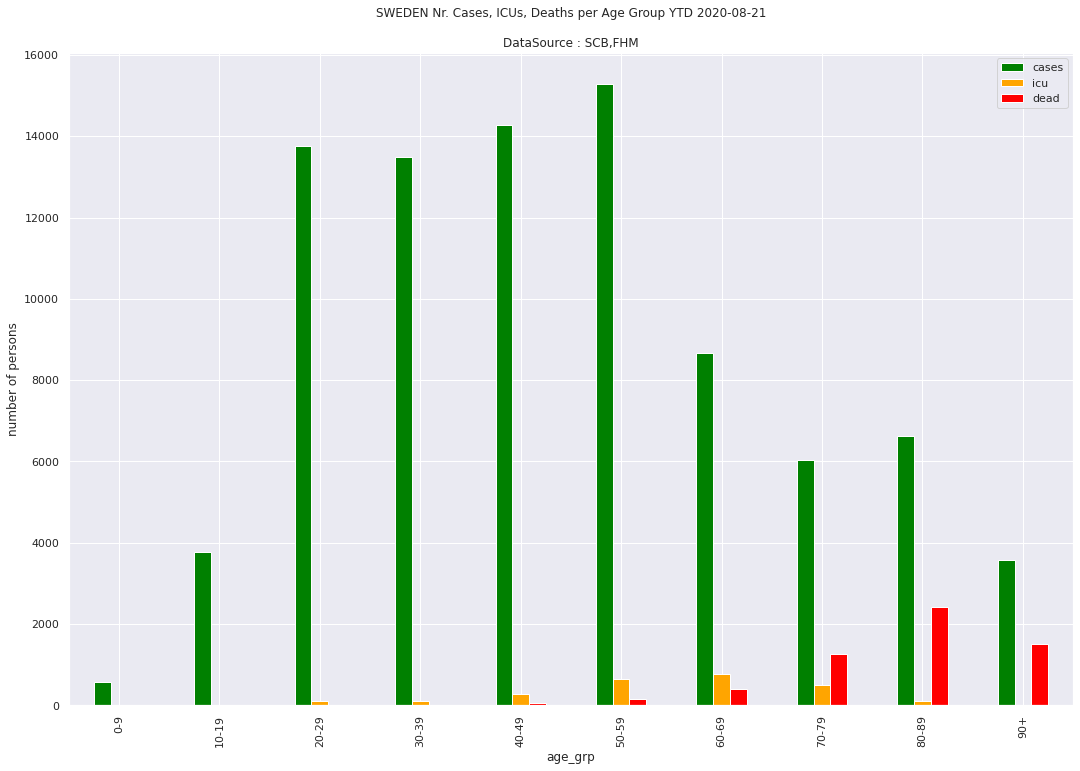

In [1125]:
fhm_age_grp.plot(kind='bar',
                 figsize=(18,12),
                 color=['green','orange','red'],
                title='SWEDEN Nr. Cases, ICUs, Deaths per Age Group YTD {}\n\nDataSource : SCB,FHM'.format(last_day))
plt.ylabel('number of persons')
plt.savefig('fhm_case_icu_deaths.jpg',format='jpg')

In [1126]:
fhm_data_per_age_group_capita = fhm_age_grp.div(population_age_grp['pop'],axis=0)
fhm_data_per_age_group_capita

,cases,icu,dead
age_grp,,,
0-9,0.000469,0.000007,8.157924e-07
10-19,0.003209,0.000013,0.000000e+00
20-29,0.010374,0.000071,7.533553e-06
30-39,0.009863,0.000086,1.170884e-05
40-49,0.010998,0.000220,3.465924e-05
50-59,0.011776,0.000502,1.248206e-04
60-69,0.007816,0.000693,3.599660e-04
70-79,0.006090,0.000511,1.265909e-03
80-89,0.015160,0.000245,5.521218e-03


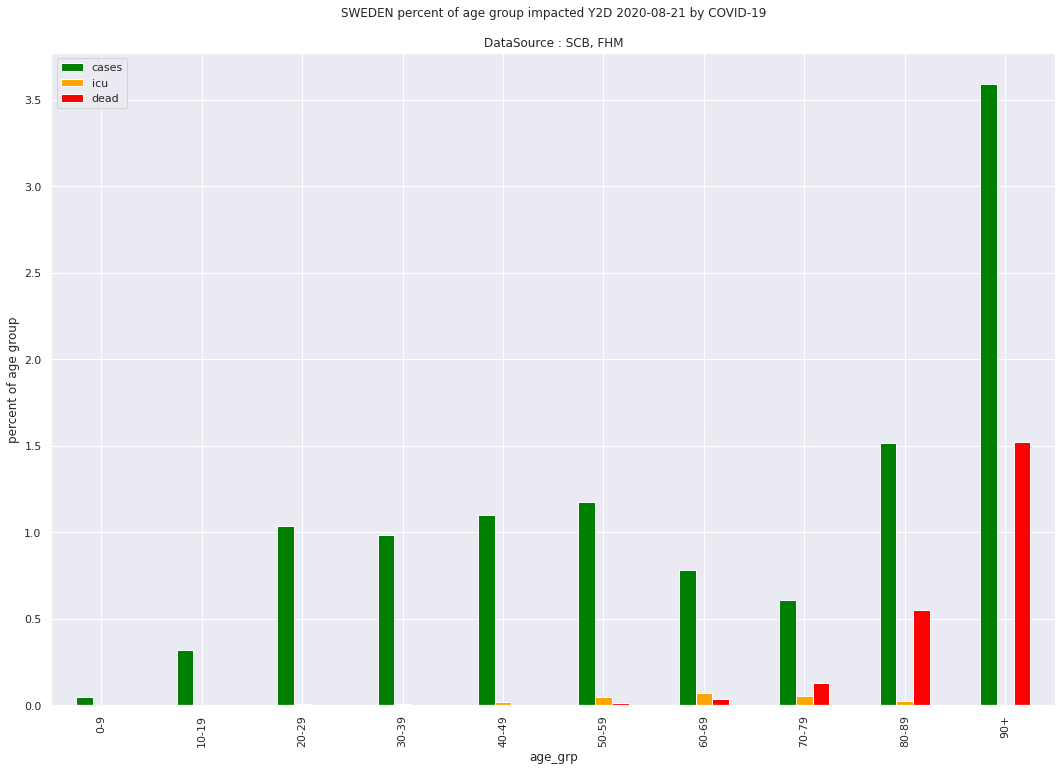

In [1127]:
(100 * fhm_data_per_age_group_capita).plot(kind='bar',title='SWEDEN percent of age group impacted Y2D {} by COVID-19\n\nDataSource : SCB, FHM'.format(last_day),
                                           figsize=(18,12),color=['green','orange','red'])
plt.ylabel('percent of age group')
plt.savefig('fhm_pct_age_grp_impacted.jpg',format='jpg')

In [1128]:
scb_deaths = scb_deaths_orig # include all dates
scb_deaths


,2015,2016,2017,2018,2019,2020,2015-2019,excess,cumexcess,excess_19,cumexcess_19
date,,,,,,,,,,,
2020-01-01,298.082,250.398,347.327,282.527,309.139,260.704,297.633,-36.9289,-36.9289,11.5056,11.5056
2020-01-02,274.842,277.992,324.786,320.54,284.408,307.918,296.61,11.3081,-25.6208,-12.2027,-0.697098
2020-01-03,283.936,299.455,317.614,303.075,279.255,262.757,296.61,-33.8533,-59.4741,-17.355,-18.0521
2020-01-04,258.675,265.728,312.491,292.801,290.59,279.179,284.337,-5.15744,-64.6315,6.25361,-11.7985
2020-01-05,270.8,265.728,311.467,298.965,283.377,271.995,286.382,-14.3878,-79.0193,-3.00522,-14.8037
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-17,212.194,214.626,216.183,230.131,214.336,190.909,217.855,-26.9458,4040.08,-3.51899,-2381.86
2020-08-18,212.194,233.023,240.772,197.255,221.549,164.223,220.924,-56.7004,3983.38,0.625865,-2381.24
2020-08-19,243.518,217.693,252.042,209.584,212.275,89.2964,227.06,-137.764,3845.62,-14.7851,-2396.02


In [1129]:
fhm_dead = pd.read_csv('fhm_scb_dead.csv',sep=';',header=0,index_col=0,parse_dates=True,names=['fhm_dead'])
fhm_dead

,fhm_dead
2020-03-12,0
2020-03-13,1
2020-03-14,1
2020-03-15,2
2020-03-16,2
...,...
2020-08-16,0
2020-08-17,0
2020-08-18,2
2020-08-19,0


In [1130]:
cmp_deaths = fhm_dead.join(scb_deaths['2020'])


In [1131]:
cmp_deaths.dropna(inplace=True)

In [1132]:
cmp_deaths['pct_covid'] = cmp_deaths['fhm_dead'] / cmp_deaths['2020']
cmp_deaths['non_covid'] = cmp_deaths['2020'] - cmp_deaths['fhm_dead']
cmp_deaths.columns=['covid_dead','all_dead','pct_covid','non_covid_dead']
cmp_deaths['pct_non_covid'] = cmp_deaths['non_covid_dead'] / cmp_deaths['all_dead']
cmp_deaths

,covid_dead,all_dead,pct_covid,non_covid_dead,pct_non_covid
2020-03-12,0,264.81,0,264.81,1
2020-03-13,1,249.414,0.0040094,248.414,0.995991
2020-03-14,1,252.493,0.0039605,251.493,0.996039
2020-03-15,2,250.44,0.00798593,248.44,0.992014
2020-03-16,2,300.734,0.0066504,298.734,0.99335
...,...,...,...,...,...
2020-08-16,0,176.54,0,176.54,1
2020-08-17,0,190.909,0,190.909,1
2020-08-18,2,164.223,0.0121785,162.223,0.987821
2020-08-19,0,89.2964,0,89.2964,1


In [1133]:
cmp_deaths = cmp_deaths.astype(float)

In [1134]:
covid_death_pct_in_period = cmp_deaths.sum()['covid_dead'] / cmp_deaths.sum()['all_dead']
covid_death_pct_in_period

0.1330778293872226

In [1135]:
covid_death_pct_YTD = cmp_deaths.sum()['covid_dead'] / scb_deaths['2020'].sum()
covid_death_pct_YTD

0.09299493687111454

In [1136]:
days_of_year = pd.to_datetime(last_stable_day).dayofyear
year_fraction = days_of_year / 365

pred_covid_deaths = cmp_deaths.sum()['covid_dead'] * (1 / year_fraction) #worst case! 

pred_death_pct = cmp_deaths.sum()['covid_dead'] / (scb_deaths['2020'].sum() * (1/year_fraction))
pred_death_pct
pred_covid_deaths

9332.422907488986

<BarContainer object of 162 artists>

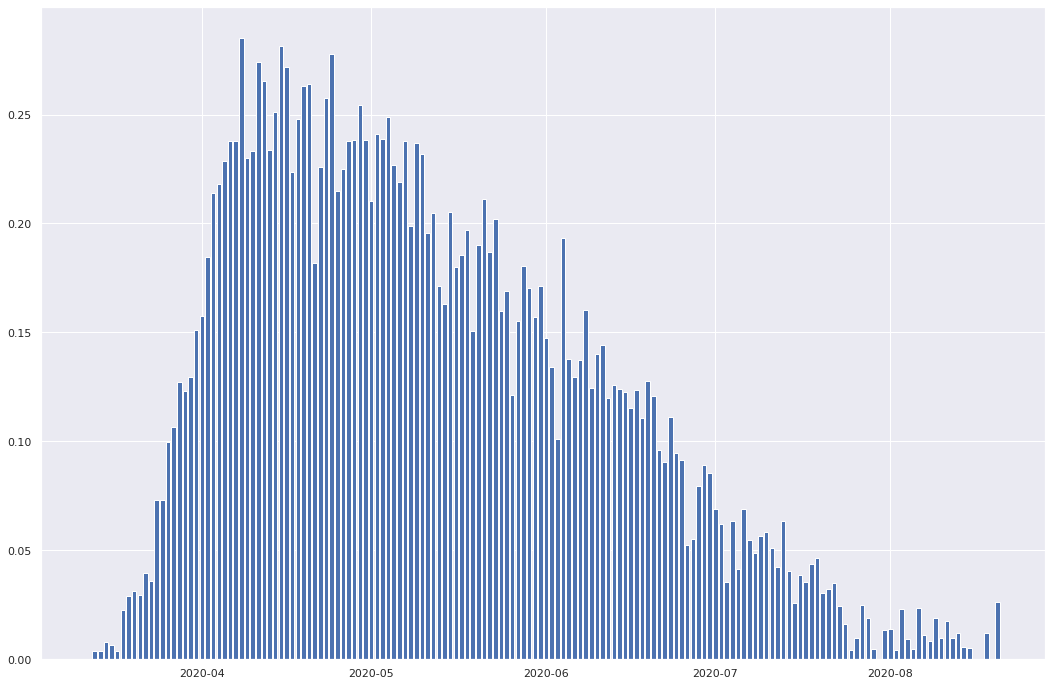

In [1137]:
plt.figure(figsize=(18,12))
plt.bar(cmp_deaths.index.date,cmp_deaths['pct_covid'])


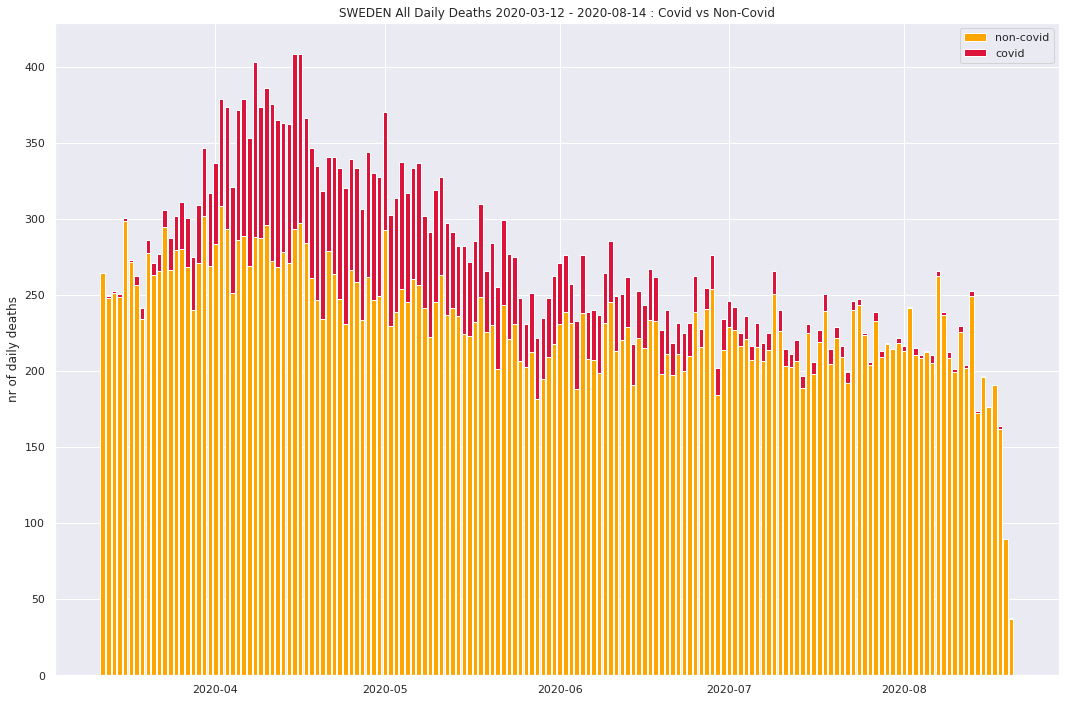

In [1138]:

plt.figure(figsize=(18,12))
plt.bar(cmp_deaths.index.date,cmp_deaths['non_covid_dead'],color='orange',label='non-covid')
plt.bar(cmp_deaths.index.date,cmp_deaths['covid_dead'],bottom=cmp_deaths['non_covid_dead'],
        color='crimson',label='covid')

plt.legend(loc='upper right')
plt.title('SWEDEN All Daily Deaths 2020-03-12 - 2020-08-14 : Covid vs Non-Covid')
plt.ylabel('nr of daily deaths')
plt.savefig('fhm_covid_vs_non_covid_deaths_abs.jpg',format='jpg')

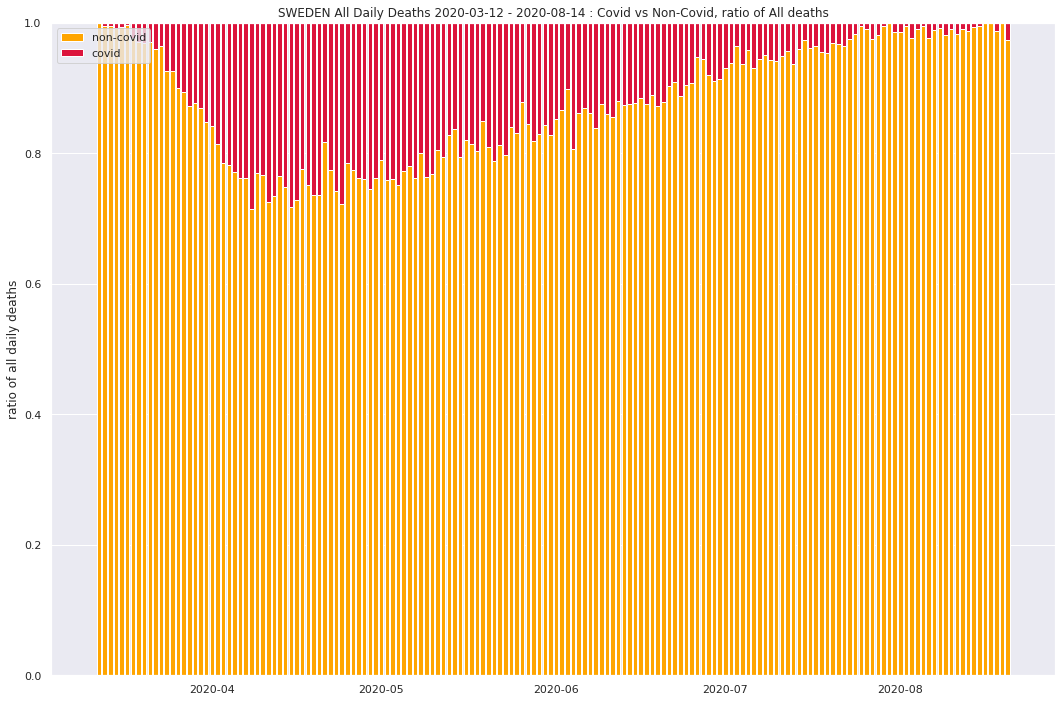

In [1139]:
plt.figure(figsize=(18,12))
plt.bar(cmp_deaths.index.date,cmp_deaths['pct_non_covid'],color='orange',label='non-covid')
plt.bar(cmp_deaths.index.date,cmp_deaths['pct_covid'],bottom=cmp_deaths['pct_non_covid'],
        color='crimson',label='covid')

plt.legend(loc='upper left')
plt.title('SWEDEN All Daily Deaths 2020-03-12 - 2020-08-14 : Covid vs Non-Covid, ratio of All deaths')
plt.ylabel('ratio of all daily deaths')
plt.savefig('fhm_covid_vs_non_covid_deaths_rel.jpg',format='jpg')

In [1140]:
first_day = pd.to_datetime("2020-03-12")
first_day.day_name()

'Thursday'

In [1141]:
weekly_scb = scb_deaths.loc[:,'2015' : '2020'].resample('W-TUE').sum()
weekly_scb

,2015,2016,2017,2018,2019,2020
date,,,,,,
2020-01-07,1957.237177,1886.668993,2245.840352,2052.688932,2024.859224,1927.569786
2020-01-14,1974.414788,1945.946784,2160.801689,1994.128737,1856.893802,1916.279442
2020-01-21,1957.237177,2012.378790,2139.285882,1998.238224,1887.807683,1838.273422
2020-01-28,1949.153596,2020.555037,1969.208556,1980.772903,1862.046116,1841.352607
2020-02-04,1986.540160,1973.541617,1959.987497,1904.747387,1927.995729,1841.352607
2020-02-11,1938.038671,1955.145062,1878.022520,2037.278354,1903.264624,1819.798313
2020-02-18,2071.417766,1822.281048,2053.222657,2079.400600,1807.431592,1871.118062
2020-02-25,2171.452088,1915.285857,2121.868325,2173.918809,1906.356012,1822.877498
2020-03-03,1761.210325,1845.787758,1794.008420,1928.376939,1539.511288,1797.217623


In [1142]:
weekly_fhm = fhm_dead.resample('W-TUE').sum()
weekly_fhm

,fhm_dead
2020-03-17,7
2020-03-24,73
2020-03-31,251
2020-04-07,532
2020-04-14,667
2020-04-21,628
2020-04-28,555
2020-05-05,544
2020-05-12,481
2020-05-19,357


In [1143]:
weekly_deaths = weekly_scb.join(weekly_fhm,how='outer')
weekly_deaths.rename(columns={'fhm_dead' : 'covid_dead'},inplace=True)
weekly_deaths['covid_dead'].fillna(0,inplace=True)
weekly_deaths

,2015,2016,2017,2018,2019,2020,covid_dead
2020-01-07,1957.237177,1886.668993,2245.840352,2052.688932,2024.859224,1927.569786,0.0
2020-01-14,1974.414788,1945.946784,2160.801689,1994.128737,1856.893802,1916.279442,0.0
2020-01-21,1957.237177,2012.378790,2139.285882,1998.238224,1887.807683,1838.273422,0.0
2020-01-28,1949.153596,2020.555037,1969.208556,1980.772903,1862.046116,1841.352607,0.0
2020-02-04,1986.540160,1973.541617,1959.987497,1904.747387,1927.995729,1841.352607,0.0
2020-02-11,1938.038671,1955.145062,1878.022520,2037.278354,1903.264624,1819.798313,0.0
2020-02-18,2071.417766,1822.281048,2053.222657,2079.400600,1807.431592,1871.118062,0.0
2020-02-25,2171.452088,1915.285857,2121.868325,2173.918809,1906.356012,1822.877498,0.0
2020-03-03,1761.210325,1845.787758,1794.008420,1928.376939,1539.511288,1797.217623,0.0
2020-03-10,2049.187917,1938.792568,1919.005008,2281.792852,1741.481979,1879.329222,0.0


In [1144]:
weekly_deaths['2015-2018'] = weekly_deaths.loc[:,'2015' : '2018'].mean(axis=1)
weekly_deaths['non_covid_dead'] = weekly_deaths['2020'] - weekly_deaths['covid_dead']
weekly_deaths.index = weekly_deaths.index.date
weekly_deaths['max'] = weekly_deaths.loc[:,'2015' :'2018'].max(axis=1)
weekly_deaths['min'] = weekly_deaths.loc[:,'2015' :'2018'].min(axis=1)
weekly_deaths = weekly_deaths[:-1]
weekly_deaths

,2015,2016,2017,2018,2019,2020,covid_dead,2015-2018,non_covid_dead,max,min
2020-01-07,1957.237177,1886.668993,2245.840352,2052.688932,2024.859224,1927.569786,0.0,2035.608863,1927.569786,2245.840352,1886.668993
2020-01-14,1974.414788,1945.946784,2160.801689,1994.128737,1856.893802,1916.279442,0.0,2018.822999,1916.279442,2160.801689,1945.946784
2020-01-21,1957.237177,2012.378790,2139.285882,1998.238224,1887.807683,1838.273422,0.0,2026.785019,1838.273422,2139.285882,1957.237177
2020-01-28,1949.153596,2020.555037,1969.208556,1980.772903,1862.046116,1841.352607,0.0,1979.922523,1841.352607,2020.555037,1949.153596
2020-02-04,1986.540160,1973.541617,1959.987497,1904.747387,1927.995729,1841.352607,0.0,1956.204165,1841.352607,1986.540160,1904.747387
2020-02-11,1938.038671,1955.145062,1878.022520,2037.278354,1903.264624,1819.798313,0.0,1952.121152,1819.798313,2037.278354,1878.022520
2020-02-18,2071.417766,1822.281048,2053.222657,2079.400600,1807.431592,1871.118062,0.0,2006.580518,1871.118062,2079.400600,1822.281048
2020-02-25,2171.452088,1915.285857,2121.868325,2173.918809,1906.356012,1822.877498,0.0,2095.631270,1822.877498,2173.918809,1915.285857
2020-03-03,1761.210325,1845.787758,1794.008420,1928.376939,1539.511288,1797.217623,0.0,1832.345861,1797.217623,1928.376939,1761.210325
2020-03-10,2049.187917,1938.792568,1919.005008,2281.792852,1741.481979,1879.329222,0.0,2047.194586,1879.329222,2281.792852,1919.005008


Text(0, 0.5, 'number of deaths per week')

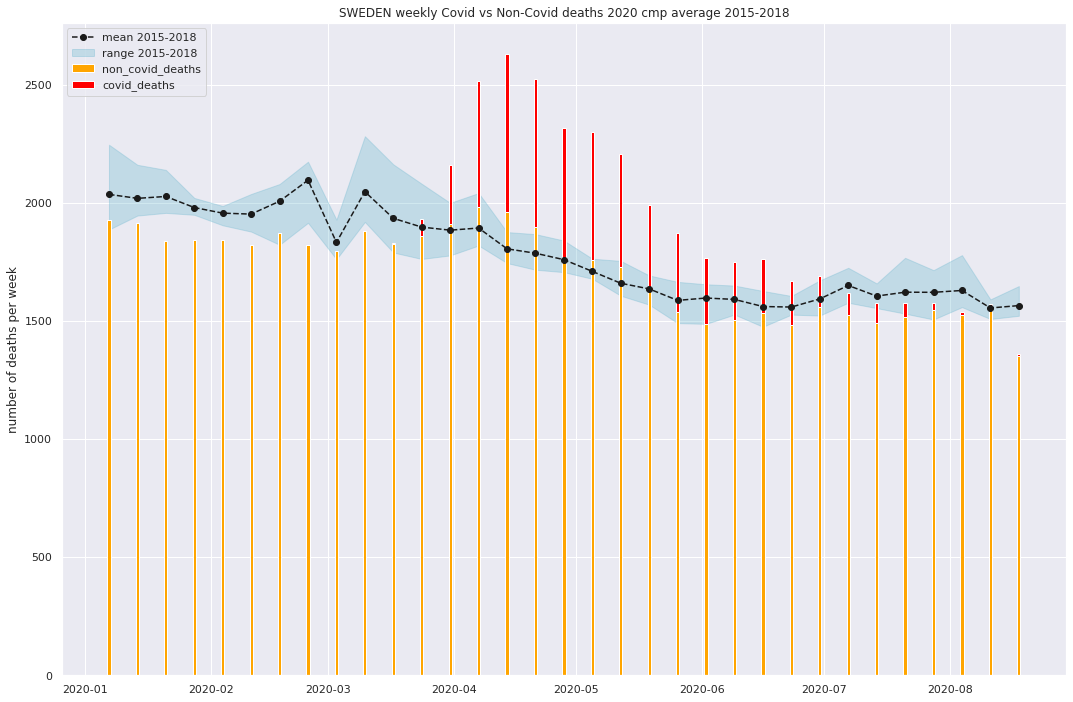

In [1145]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN weekly Covid vs Non-Covid deaths 2020 cmp average 2015-2018')
plt.bar(weekly_deaths.index,weekly_deaths['non_covid_dead'],label='non_covid_deaths',color='orange')
plt.bar(weekly_deaths.index,weekly_deaths['covid_dead'],bottom=weekly_deaths['non_covid_dead'],
       label='covid_deaths',color='red')
plt.plot(weekly_deaths.index,weekly_deaths['2015-2018'],'o--',color='k',label='mean 2015-2018')

plt.fill_between(weekly_deaths.index,weekly_deaths['min'],weekly_deaths['max'],color='c',alpha=0.3,
                label='range 2015-2018')

plt.legend(loc='upper left')
plt.ylabel('number of deaths per week')

In [1146]:
population

,population,growth
year,,
2014,9747355,NaN
2015,9851017,1.010635
2016,9995153,1.014632
2017,10120242,1.012515
2018,10230185,1.010864
2019,10327589,1.009521
2020,10327589,NaN


In [1147]:
# pop from end of previous year
pop = population.shift()
pop = pop['population']
pop['covid_dead'] = pop['2020']
pop.dropna(inplace=True)
pop

year
2015           9747355.0
2016           9851017.0
2017           9995153.0
2018          10120242.0
2019          10230185.0
2020          10327589.0
covid_dead    10327589.0
Name: population, dtype: float64

In [1148]:
weekly_pop_adjusted_deaths = weekly_deaths.loc[:,'2015' : 'covid_dead'].copy()
weekly_pop_adjusted_deaths = weekly_pop_adjusted_deaths / (pop / 1e6)
weekly_pop_adjusted_deaths['2015-2018'] = weekly_pop_adjusted_deaths.loc[:,'2015' : '2018'].mean(axis=1)
weekly_pop_adjusted_deaths['min'] = weekly_pop_adjusted_deaths.loc[:,'2015' : '2018'].min(axis=1)
weekly_pop_adjusted_deaths['max'] = weekly_pop_adjusted_deaths.loc[:,'2015' : '2018'].max(axis=1)

weekly_pop_adjusted_deaths['non_covid_dead'] = weekly_pop_adjusted_deaths['2020'] - weekly_pop_adjusted_deaths['covid_dead']
weekly_pop_adjusted_deaths['week_idx'] = range(len(weekly_pop_adjusted_deaths))
weekly_pop_adjusted_deaths

,2015,2016,2017,2018,2019,2020,covid_dead,2015-2018,min,max,non_covid_dead,week_idx
2020-01-07,200.796747,191.520225,224.692944,202.830024,197.929874,186.642767,0.000000,204.959985,191.520225,224.692944,186.642767,0
2020-01-14,202.559031,197.537654,216.184954,197.043582,181.511263,185.549545,0.000000,203.331305,197.043582,216.184954,185.549545,1
2020-01-21,200.796747,204.281323,214.032330,197.449648,184.533093,177.996377,0.000000,204.140012,197.449648,214.032330,177.996377,2
2020-01-28,199.967437,205.111314,197.016349,195.723867,182.014902,178.294528,0.000000,199.454742,195.723867,205.111314,178.294528,3
2020-02-04,203.802997,200.338870,196.093796,188.211644,188.461473,178.294528,0.000000,197.111827,188.211644,203.802997,178.294528,4
2020-02-11,198.827135,198.471393,187.893324,201.307276,186.044008,176.207468,0.000000,196.624782,187.893324,201.307276,176.207468,5
2020-02-18,212.510755,184.984053,205.421834,205.469454,176.676335,181.176658,0.000000,202.096524,184.984053,212.510755,181.176658,6
2020-02-25,222.773469,194.425191,212.289729,214.808975,186.346191,176.505620,0.000000,211.074341,194.425191,222.773469,176.505620,7
2020-03-03,180.685973,187.370274,179.487840,190.546524,150.487141,174.021025,0.000000,184.522653,179.487840,190.546524,174.021025,8
2020-03-10,210.230151,196.811412,191.993560,225.468210,170.229764,181.971729,0.000000,206.125834,191.993560,225.468210,181.971729,9


In [1149]:
excess = weekly_pop_adjusted_deaths['2020'] - weekly_pop_adjusted_deaths['2015-2018']
excess

2020-01-07   -18.317218
2020-01-14   -17.781760
2020-01-21   -26.143635
2020-01-28   -21.160214
2020-02-04   -18.817299
2020-02-11   -20.417314
2020-02-18   -20.919866
2020-02-25   -34.568721
2020-03-03   -10.501628
2020-03-10   -24.154105
2020-03-17   -17.414837
2020-03-24    -3.995227
2020-03-31    19.489825
2020-04-07    52.786209
2020-04-14    72.780572
2020-04-21    64.332484
2020-04-28    47.270222
2020-05-05    50.520260
2020-05-12    46.599413
2020-05-19    27.794169
2020-05-26    21.245763
2020-06-02    10.091761
2020-06-09     8.973216
2020-06-16    13.127911
2020-06-23     4.730605
2020-06-30     3.155200
2020-07-07    -9.724737
2020-07-14    -9.250307
2020-07-21   -10.801501
2020-07-28   -10.643040
2020-08-04   -14.931975
2020-08-11    -4.393097
2020-08-18   -26.071211
dtype: float64

In [1150]:
cum_excess = excess.cumsum()
cum_excess

2020-01-07    -18.317218
2020-01-14    -36.098978
2020-01-21    -62.242614
2020-01-28    -83.402827
2020-02-04   -102.220126
2020-02-11   -122.637440
2020-02-18   -143.557305
2020-02-25   -178.126027
2020-03-03   -188.627655
2020-03-10   -212.781760
2020-03-17   -230.196597
2020-03-24   -234.191824
2020-03-31   -214.701999
2020-04-07   -161.915789
2020-04-14    -89.135218
2020-04-21    -24.802733
2020-04-28     22.467489
2020-05-05     72.987749
2020-05-12    119.587162
2020-05-19    147.381331
2020-05-26    168.627094
2020-06-02    178.718855
2020-06-09    187.692071
2020-06-16    200.819981
2020-06-23    205.550586
2020-06-30    208.705786
2020-07-07    198.981049
2020-07-14    189.730743
2020-07-21    178.929242
2020-07-28    168.286202
2020-08-04    153.354227
2020-08-11    148.961129
2020-08-18    122.889918
dtype: float64

In [1151]:
cum_excess * (pop['2020'] / 1e6)

2020-01-07    -189.172701
2020-01-14    -372.815411
2020-01-21    -642.816133
2020-01-28    -861.350123
2020-02-04   -1055.687451
2020-02-11   -1266.549075
2020-02-18   -1482.600849
2020-02-25   -1839.612393
2020-03-03   -1948.068891
2020-03-10   -2197.522559
2020-03-17   -2377.375839
2020-03-24   -2418.636905
2020-03-31   -2217.354001
2020-04-07   -1672.199725
2020-04-14    -920.551895
2020-04-21    -256.152436
2020-04-28     232.034991
2020-05-05     753.787469
2020-05-12    1235.047054
2020-05-19    1522.093811
2020-05-26    1741.511320
2020-06-02    1845.734881
2020-06-09    1938.406563
2020-06-16    2073.986228
2020-06-23    2122.841970
2020-06-30    2155.427581
2020-07-07    2054.994497
2020-07-14    1959.461131
2020-07-21    1847.907670
2020-07-28    1737.990729
2020-08-04    1583.779423
2020-08-11    1538.409320
2020-08-18    1269.156564
dtype: float64

In [1152]:
last_week = cum_excess.index[-1]

Text(0, 0.5, 'cumulative excess deaths per million')

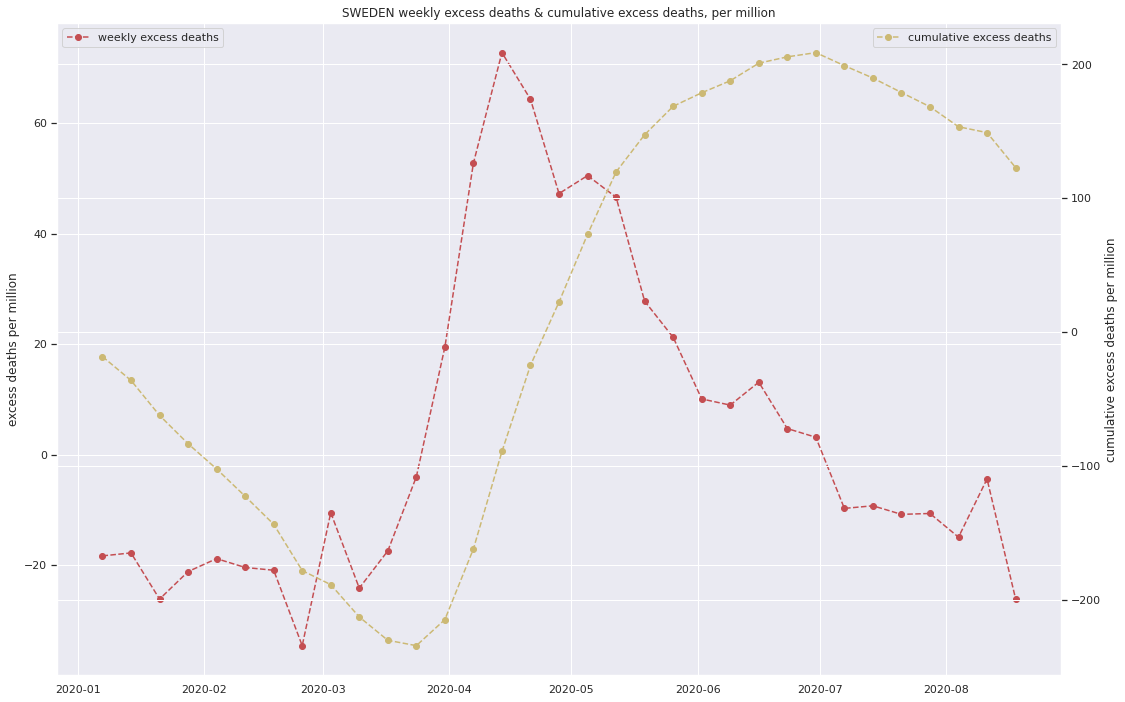

In [1153]:

ax = excess.plot(figsize=(18,12),style='ro--',label='weekly excess deaths',
                title='SWEDEN weekly excess deaths & cumulative excess deaths, per million')
ax2 = plt.twinx()

cum_excess.plot(ax=ax2,style='yo--',label='cumulative excess deaths')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_ylabel('excess deaths per million')
ax2.set_ylabel('cumulative excess deaths per million')

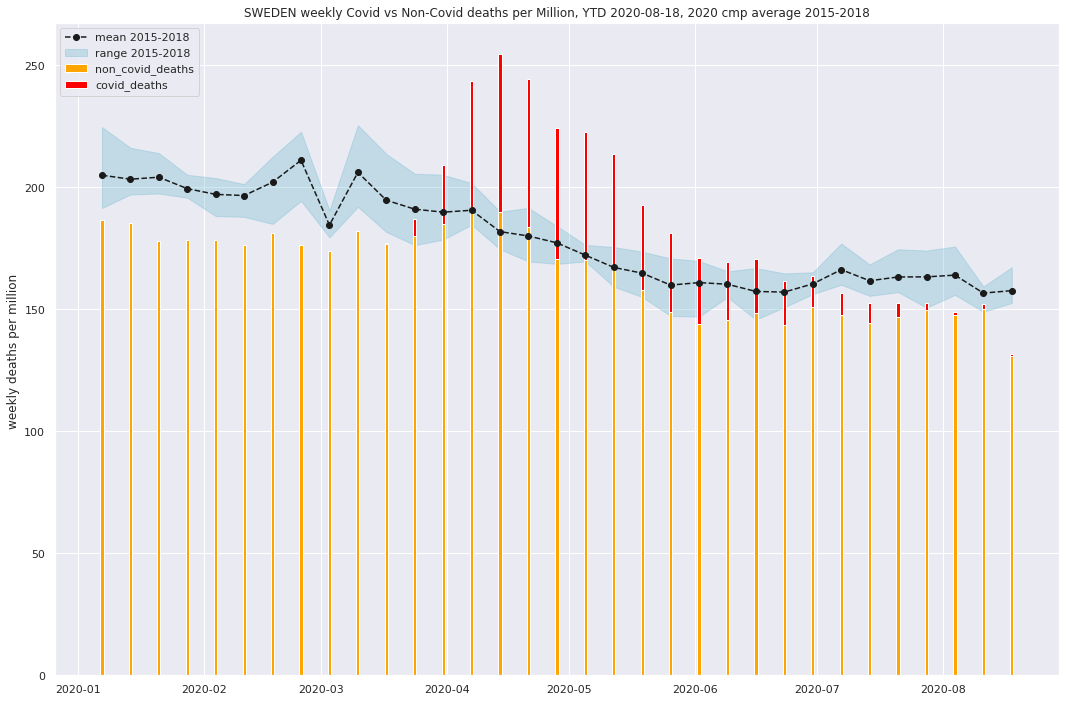

In [1154]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN weekly Covid vs Non-Covid deaths per Million, YTD {}, 2020 cmp average 2015-2018'.format(last_week))
plt.bar(weekly_pop_adjusted_deaths.index,weekly_pop_adjusted_deaths['non_covid_dead'],label='non_covid_deaths',color='orange')
plt.bar(weekly_pop_adjusted_deaths.index,weekly_pop_adjusted_deaths['covid_dead'],bottom=weekly_pop_adjusted_deaths['non_covid_dead'],
       label='covid_deaths',color='red')
plt.plot(weekly_pop_adjusted_deaths.index,weekly_pop_adjusted_deaths['2015-2018'],'o--',color='k',label='mean 2015-2018')

plt.fill_between(weekly_pop_adjusted_deaths.index,weekly_pop_adjusted_deaths['min'],weekly_pop_adjusted_deaths['max'],color='c',alpha=0.3,
                label='range 2015-2018')

plt.legend(loc='upper left')
plt.ylabel('weekly deaths per million ')

plt.savefig('fhm_weekly_covid_non_covid_per_m.jpg',format='jpg')

In [1155]:
weekly_pop_adjusted_deaths.sum() * (pop / 1e6) 

2015              58645.373527
2015-2018                  NaN
2016              57549.536472
2017              58744.298540
2018              59659.482617
2019              55917.028456
2020              62281.647837
covid_dead         5803.000000
max                        NaN
min                        NaN
non_covid_dead             NaN
week_idx                   NaN
dtype: float64

In [1156]:
import pymc3 as pm
import arviz as az

data = weekly_pop_adjusted_deaths.loc[:,'2015' : '2020'].copy()

data

,2015,2016,2017,2018,2019,2020
2020-01-07,200.796747,191.520225,224.692944,202.830024,197.929874,186.642767
2020-01-14,202.559031,197.537654,216.184954,197.043582,181.511263,185.549545
2020-01-21,200.796747,204.281323,214.032330,197.449648,184.533093,177.996377
2020-01-28,199.967437,205.111314,197.016349,195.723867,182.014902,178.294528
2020-02-04,203.802997,200.338870,196.093796,188.211644,188.461473,178.294528
2020-02-11,198.827135,198.471393,187.893324,201.307276,186.044008,176.207468
2020-02-18,212.510755,184.984053,205.421834,205.469454,176.676335,181.176658
2020-02-25,222.773469,194.425191,212.289729,214.808975,186.346191,176.505620
2020-03-03,180.685973,187.370274,179.487840,190.546524,150.487141,174.021025
2020-03-10,210.230151,196.811412,191.993560,225.468210,170.229764,181.971729


In [1157]:
data=data.T.unstack().reset_index()
data.columns=['date','year','dead_per_M']
data

,date,year,dead_per_M
0,2020-01-07,2015,200.796747
1,2020-01-07,2016,191.520225
2,2020-01-07,2017,224.692944
3,2020-01-07,2018,202.830024
4,2020-01-07,2019,197.929874
...,...,...,...
193,2020-08-18,2016,167.243013
194,2020-08-18,2017,154.681411
195,2020-08-18,2018,152.579343
196,2020-08-18,2019,149.681319


In [1158]:
unique_years = data.year.unique()
year_idx_map = dict(zip(unique_years,range(len(unique_years))))

data['year_idx'] = data['year'].apply(lambda y :year_idx_map[y])

unique_weeks = data.date.unique()
week_idx_map = dict(zip(unique_weeks,range(len(unique_weeks))))
data['week_idx'] = data['date'].apply(lambda d : week_idx_map[d])
data

,date,year,dead_per_M,year_idx,week_idx
0,2020-01-07,2015,200.796747,0,0
1,2020-01-07,2016,191.520225,1,0
2,2020-01-07,2017,224.692944,2,0
3,2020-01-07,2018,202.830024,3,0
4,2020-01-07,2019,197.929874,4,0
...,...,...,...,...,...
193,2020-08-18,2016,167.243013,1,32
194,2020-08-18,2017,154.681411,2,32
195,2020-08-18,2018,152.579343,3,32
196,2020-08-18,2019,149.681319,4,32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_, lambda_bar]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.


                mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
lambda_bar     0.006  0.001     0.004      0.007      0.000    0.000   
lambda_[0]   199.971  5.622   191.687    209.267      0.128    0.091   
lambda_[1]   196.383  5.497   187.797    205.181      0.109    0.077   
lambda_[2]   195.989  5.657   186.832    204.667      0.108    0.077   
lambda_[3]   192.539  5.799   182.043    200.599      0.111    0.079   
lambda_[4]   192.342  5.863   182.310    200.685      0.108    0.077   
lambda_[5]   191.180  5.686   181.366    199.560      0.114    0.081   
lambda_[6]   193.657  5.370   185.202    202.376      0.111    0.079   
lambda_[7]   200.726  5.788   191.329    209.200      0.120    0.085   
lambda_[8]   176.641  5.622   167.579    185.345      0.104    0.073   
lambda_[9]   195.518  5.657   185.942    204.148      0.113    0.080   
lambda_[10]  189.456  5.737   180.675    198.986      0.124    0.088   
lambda_[11]  185.422  5.391   177.045    193.731      0.109    0

/usr/local/lib/python3.8/site-packages/arviz/plots/traceplot.py:250: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (34), generating only 20 plots
  warnings.warn(


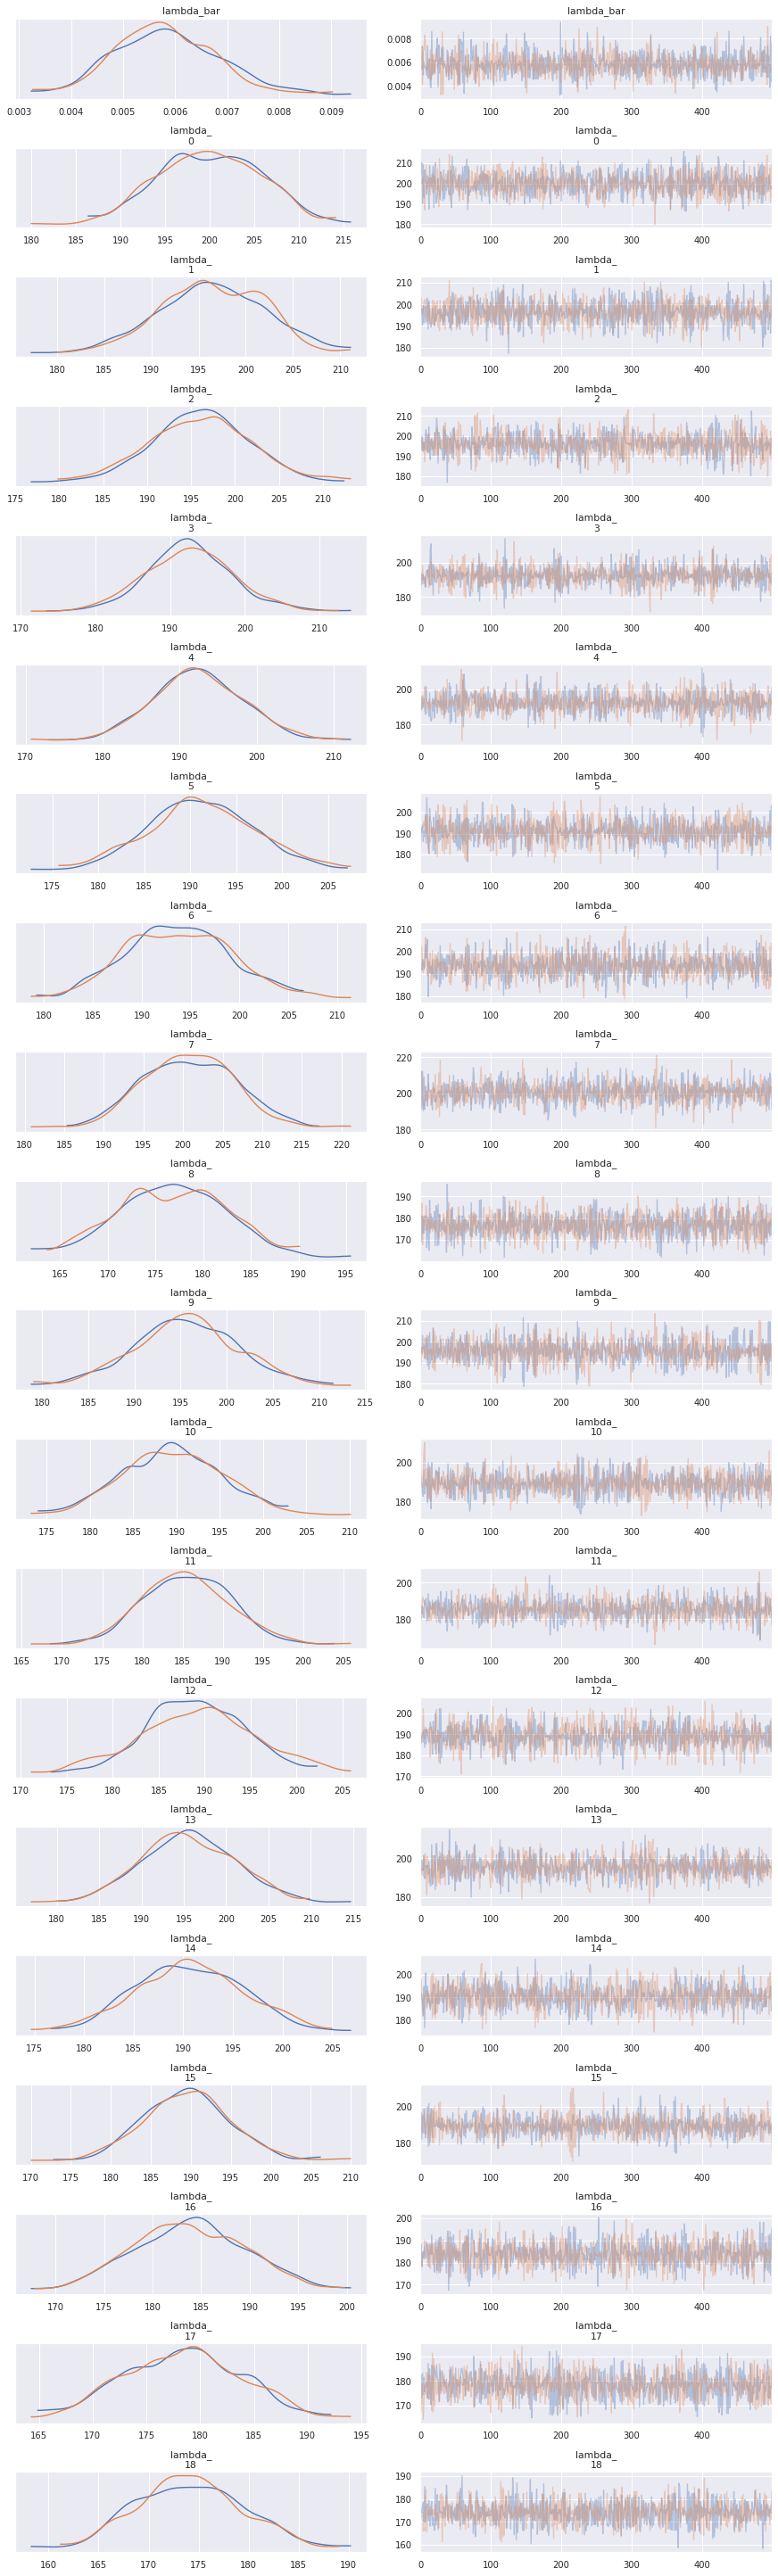

In [1159]:
import pymc3 as pm
import arviz as az

year_idx = data['year_idx'].values
week_idx = data['week_idx'].values

model = pm.Model()
with model:
    
    lambda_bar = pm.Exponential('lambda_bar',1 / data['dead_per_M'].mean())
    lambda_ = pm.Exponential('lambda_',lambda_bar,shape=len(unique_weeks))
    lkh = pm.Poisson('lkh', lambda_[week_idx],observed=data['dead_per_M'])
    
    trace = pm.sample(500,tune=500)
    result = pm.trace_to_dataframe(trace)
    print (az.summary(trace,hdi_prob=0.89))
    _= az.plot_trace(trace)

In [1160]:
result = result.iloc[:,1:]
result.describe()


,lambda___0,lambda___1,lambda___2,lambda___3,lambda___4,lambda___5,lambda___6,lambda___7,lambda___8,lambda___9,...,lambda___23,lambda___24,lambda___25,lambda___26,lambda___27,lambda___28,lambda___29,lambda___30,lambda___31,lambda___32
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,199.971242,196.382983,195.988660,192.539349,192.342125,191.180063,193.656759,200.726375,176.641487,195.518111,...,156.767178,156.420114,159.257420,161.966134,158.823964,158.836639,159.434526,158.905072,155.622396,151.659651
std,5.621892,5.497362,5.657371,5.798914,5.863137,5.685507,5.370252,5.787832,5.622278,5.657077,...,4.927919,4.947991,4.923028,4.993666,4.854104,5.048264,4.837205,5.134259,4.850505,5.211638
min,179.980797,177.266288,176.804781,171.406059,170.739773,172.699390,178.682392,180.823730,161.927552,178.789248,...,140.926658,143.252850,142.512575,148.287573,142.566523,143.321144,144.159673,140.896805,139.233723,136.594684
25%,195.991193,192.510568,192.271891,188.626806,188.550629,187.417777,189.738728,196.695501,172.704887,191.899335,...,153.515502,152.990919,155.938676,158.339499,155.721292,155.425141,156.141221,155.253891,152.326370,147.966979
50%,199.973361,196.229044,196.174222,192.508386,192.153690,190.874180,193.554679,200.699358,176.692918,195.499710,...,156.576534,156.462592,159.059906,161.911802,158.895891,158.684988,159.465919,158.884267,155.596507,151.588726
75%,204.143042,200.419457,199.633130,196.284007,196.208120,194.972049,197.320454,204.803625,180.612561,199.149579,...,160.105471,159.689055,162.761336,165.731659,162.025189,162.173656,162.570153,162.485539,158.859798,155.033367
max,215.789402,211.107524,213.146924,214.184688,212.191205,207.475066,211.368365,221.170499,195.482318,213.436423,...,172.137131,173.705390,177.720016,175.850792,176.755071,174.311375,177.356962,178.364018,168.891802,174.986240


In [1161]:
result.columns = range(len(week_idx_map))
result.describe()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,199.971242,196.382983,195.988660,192.539349,192.342125,191.180063,193.656759,200.726375,176.641487,195.518111,...,156.767178,156.420114,159.257420,161.966134,158.823964,158.836639,159.434526,158.905072,155.622396,151.659651
std,5.621892,5.497362,5.657371,5.798914,5.863137,5.685507,5.370252,5.787832,5.622278,5.657077,...,4.927919,4.947991,4.923028,4.993666,4.854104,5.048264,4.837205,5.134259,4.850505,5.211638
min,179.980797,177.266288,176.804781,171.406059,170.739773,172.699390,178.682392,180.823730,161.927552,178.789248,...,140.926658,143.252850,142.512575,148.287573,142.566523,143.321144,144.159673,140.896805,139.233723,136.594684
25%,195.991193,192.510568,192.271891,188.626806,188.550629,187.417777,189.738728,196.695501,172.704887,191.899335,...,153.515502,152.990919,155.938676,158.339499,155.721292,155.425141,156.141221,155.253891,152.326370,147.966979
50%,199.973361,196.229044,196.174222,192.508386,192.153690,190.874180,193.554679,200.699358,176.692918,195.499710,...,156.576534,156.462592,159.059906,161.911802,158.895891,158.684988,159.465919,158.884267,155.596507,151.588726
75%,204.143042,200.419457,199.633130,196.284007,196.208120,194.972049,197.320454,204.803625,180.612561,199.149579,...,160.105471,159.689055,162.761336,165.731659,162.025189,162.173656,162.570153,162.485539,158.859798,155.033367
max,215.789402,211.107524,213.146924,214.184688,212.191205,207.475066,211.368365,221.170499,195.482318,213.436423,...,172.137131,173.705390,177.720016,175.850792,176.755071,174.311375,177.356962,178.364018,168.891802,174.986240


In [1162]:
CI = result.quantile([0.055,0.945],axis=0)
CI

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0.055,191.092305,187.463852,186.931535,183.389515,183.072351,181.996740,185.126223,191.767983,167.602208,186.240635,...,149.103927,148.635766,151.785067,154.160729,151.065857,150.985079,151.862907,151.043608,148.083456,143.743608
0.945,208.665522,204.961677,204.818044,202.082284,201.555493,200.728512,202.370908,209.833182,185.350450,204.751141,...,164.702536,164.771401,166.794986,169.786692,166.477448,166.872654,166.941734,167.047273,163.261391,160.042604


In [1163]:
errors = np.abs(CI - result.describe().loc['mean'])
errors.loc[:,1:32]

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0.055,8.919131,9.057126,9.149834,9.269773,9.183323,8.530536,8.958392,9.039278,9.277476,9.067595,...,7.663251,7.784347,7.472353,7.805405,7.758107,7.851560,7.571619,7.861464,7.538940,7.916043
0.945,8.578694,8.829383,9.542936,9.213369,9.548449,8.714148,9.106807,8.708964,9.233030,9.267305,...,7.935358,8.351288,7.537566,7.820557,7.653484,8.036015,7.507208,8.142200,7.638995,8.382952


Text(0, 0.5, 'deaths per million')

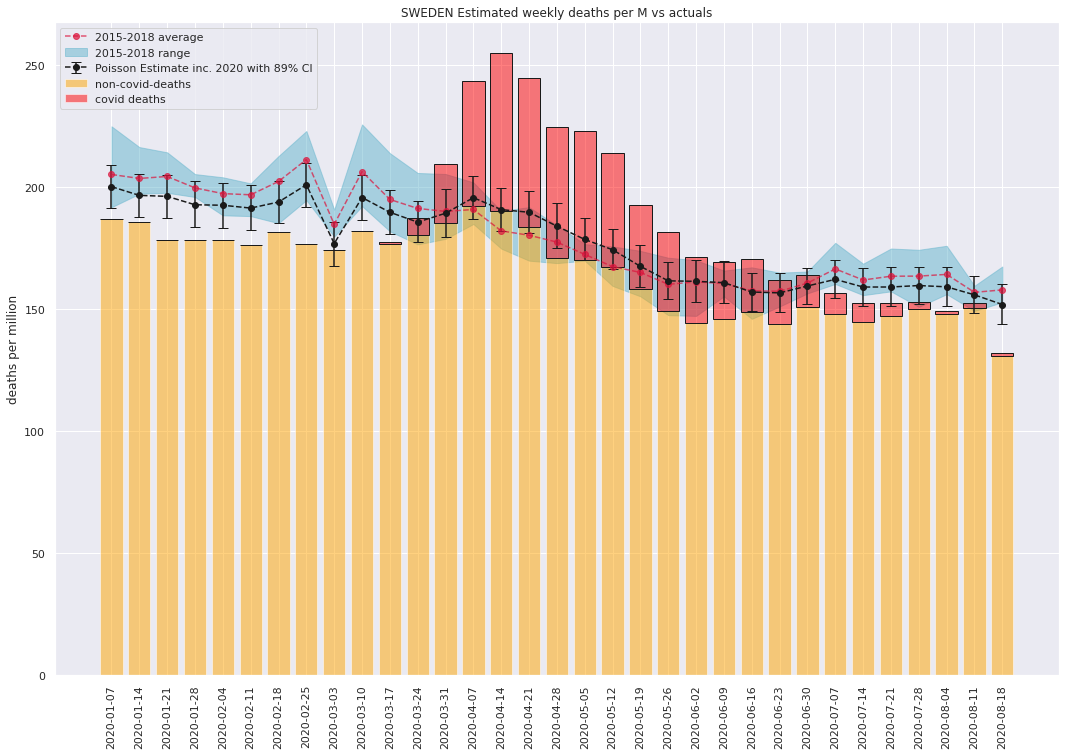

In [1164]:
plt.figure(figsize=(18,12))
plt.title('SWEDEN Estimated weekly deaths per M vs actuals')

plt.errorbar(result.columns,result.mean(),errors.values,fmt='o--',capsize=5,color='k',
            label='Poisson Estimate inc. 2020 with 89% CI')

plt.bar(result.columns,weekly_pop_adjusted_deaths['non_covid_dead'],alpha=0.5,color='orange',
        label='non-covid-deaths')

_=plt.xticks(range(len(result.columns)),weekly_pop_adjusted_deaths.index,rotation=90)

plt.bar(result.columns,weekly_pop_adjusted_deaths['covid_dead'],alpha=0.5,color='red',
        bottom=weekly_pop_adjusted_deaths['non_covid_dead'],label='covid deaths')

plt.bar(result.columns,weekly_pop_adjusted_deaths['covid_dead'],
        bottom=weekly_pop_adjusted_deaths['non_covid_dead'],edgecolor='k',alpha=1,fill=False)

plt.fill_between(result.columns,weekly_pop_adjusted_deaths['min'],weekly_pop_adjusted_deaths['max'],
                color='c',alpha=0.5,label='2015-2018 range')

plt.plot(result.columns,weekly_pop_adjusted_deaths['2015-2018'],'o--',color='crimson',alpha=0.7,
        label='2015-2018 average')

plt.legend(loc='upper left')
plt.ylabel('deaths per million')